In [1]:
# load package
# string 
import re

# date
from datetime import datetime

# math
import pandas as pd
import numpy as np
import scipy as sp
import random

# nlp
from pattern.de import parse, conjugate, singularize, pluralize

# sys
import sys
import os
import time
import warnings

# machine learning
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, gaussian_process, discriminant_analysis
from xgboost import XGBClassifier

# model utils
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection 
from sklearn import model_selection
from sklearn import metrics

# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix #??
# = show plots in Jupyter Notebook browser
%matplotlib inline 
mpl.style.use('ggplot') #??
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8 #??

# show all columns
from IPython.display import display
pd.options.display.max_columns = None

# self define
sys.path.append('../../utils/')

In [2]:
# read files
lb_wsp_2014 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2014.csv', sep = ';')
lb_wsp_2015 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2015.csv', sep = ';')
lb_wsp_2016 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2016.csv', sep = ';')
lb_wsp_2017 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2017.csv', sep = ';')
lb_wsp_2018 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2018.csv', sep = ';')
std_wsp_2014 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2014.csv', sep = ';')
std_wsp_2015 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2015.csv', sep = ';')
std_wsp_2016 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2016.csv', sep = ';')
std_wsp_2017 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2017.csv', sep = ';')
std_wsp_2018 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2018.csv', sep = ';')
# cat
d1 = lb_wsp_2014.copy()
d2 = lb_wsp_2015.copy()
d3 = lb_wsp_2016.copy()
d4 = lb_wsp_2017.copy()
d5 = lb_wsp_2018.copy()

d6 = std_wsp_2014.copy()
d7 = std_wsp_2015.copy()
d8 = std_wsp_2016.copy()
d9 = std_wsp_2017.copy()
d10 = std_wsp_2018.copy()

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# for training we use data from 14 - 17 in lb_wsp
train = pd.concat([d1,d2,d3,d4], 0)
test = d5
data = [train, test]

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001054 entries, 0 to 279792
Data columns (total 21 columns):
Auftragsnummer          1001054 non-null object
AW-Nr                   437185 non-null object
Teile-Nr                517935 non-null object
KM-Stand                1000958 non-null object
Beschreibung            1000315 non-null object
Auftragsdatum           1001054 non-null object
Markencode              995567 non-null object
Lagerortcode            1001054 non-null object
Adressanredecode        991514 non-null object
Fahrgestellnummer       996850 non-null object
Motorcode               979644 non-null object
Fahrzeugmodellnummer    995486 non-null object
Modell                  993023 non-null object
Typ                     720265 non-null object
Getriebecode            976875 non-null object
Getriebeartcode         575 non-null object
Gewicht                 995390 non-null object
Leistung (KW)           995390 non-null float64
Erstzulassungsdatum     995390 non-null

In [4]:
# 转化为auftrag table， 但是这次合并的是Teile-Nr项
# 给的数据的每一行都是一个维修项，初衷是，把属于同一个auftrag的维修项合并到一起，看一下，在同一个Auftrag中，经常一起修的是那些内容

def toAuftragTable(df, att, auftn, clean = True):
    """
    input:
        df, DataFrame:
            the dataframe
        att, string:
            the column name of the target attribute
        auftn, string:
            the column name of the aftragsnummer attribute
        clean:
            when true, drop the null item in auftn attribute.
    output:
        df_g, DataFrame:
            dataframe contrains two columns auftn and att
            type of item in att is string, separate with ';'
    """
    # assert: make sure the type of the attributes inputted
    
    # extract the att and date columns
    df = df[[att, auftn]]
    # set type to object
    #df[att] = df[att].astype('object')
    #df[auftn] = df[auftn].astype('object')
    # if clean is True, drop the fake data, like the null data
    if clean:
        print("Falls Null date exist, drop these dates directly")
        #df = df.drop(df[df[att].isnull()].index)
        df = df.drop(df[df[auftn].isnull()].index)
    # group and sum 
    df_g = df.groupby([auftn], as_index = False).apply(agg)
    return df_g

# apply 只能对单行进行处理，而不是对整个分组进行处理，所以估计应该把axis换成1，比较好
def agg(x):
    # 是否用‘ ’分隔会比较好，这样就不用对初始的属性，
    # x 在这里是dataframe？？？
    #x = [str(i) for i in x]
    x = x.apply(lambda x: ';'.join(set([str(i) for i in x])), axis = 0)
    #x = x.apply(lambda x: ' '.join(set(x)), axis = 0)
    #print(x.columns.values)
    return x

In [16]:
df_train = toAuftragTable(train, 'Teile-Nr', 'Auftragsnummer')

Null date exist, drop these dates directly


In [17]:
df_train

,Teile-Nr,Auftragsnummer
0,HDV;JLU,103K
1,JCR;GQQ,77KW
2,nan,WSAU000839
3,ZZ MET;LMW030000Z0;nan;D 330KD2A1;ZZ UBS,WSAU195981
4,N 10648301;8K0698451A;8K0127400A;N 91041702;...,WSAU198256
5,1Q1998002;071115562C;N 10591501;N 90813202;n...,WSAU200129
6,1J5853601C 739;N 0385491;N 0120053;1J0092155...,WSAU200223
7,03L903137A;071115562C;8K9955425;8K1998002A;nan...,WSAU200258
8,B 000DS;06A115561B;N 90813202;nan;8E0819439;...,WSAU200259
9,W-AN-GAR;N 0209022;nan;8P0963555G;8P0881361G,WSAU200260


In [5]:
class FreDict:
    """
    统计单词和出现的频率
    文档中的每个字都会被记录进去，所以应该确认输入的文件内容，只含有目标列属性
    """
    def __init__(self, path, header = True, sep = ';', clean = False, recover = False, singular = False):
        """
        input:
            path: string
                the path of the file
            header: boolean
                weather the file contains header of not
            sep: string
                the sep of the file in each line
            clean: boolean
                remove the word with single buchstachben or not
            recover: boolean
                transform 'ae', 'oe', 'ue', 'ss' back to 'ä', 'ö', 'ü', 'ß' usw.
            singular: boolean
                weather turns the word to singular or not
        """
        self.dict_re = {'ae': 'ä', 'oe': 'ö', 'ue': 'ü', 'ß': 'ss', 'u.': 'und ', 'fzg': 'fahrzeug', ' f ': ' für '}
        self.words, self.dict_count = self._load_data(path, header, sep, clean, recover, singular) # list of Words
        self.ls_sorted = self._sort_dict(self.words) # list of list
        self.len = len(self.words)
    
    def get_word(self, w):
        if w in self.dict_count.keys():
            return self.dict_count[w]
        else:
            return Word('x', 0, 'NAW')
    
    def get_best(self, s):
        """
        input:
            s string:
                list of words in form of string
        output:
            out string:
                the frequentest word
        """
        words = s.split(' ')
        words = [word.strip() for word in words]
        out = 'xxx'
        count = 0
        for word in words:
            tmp = self.get_word(word)
            if tmp.get_count() > count:
                out = tmp.get_word()
                count = tmp.get_count()
        return out
        
    def top(self, n = 10):
        # return list of list
        # get the top n item 
        if n == -1:
            return self.ls_sorted
        return self.ls_sorted[:n]
    
    def top_norm(self, n = 10):
        # get the top n norm
        out = []
        counter = 0
        for i in self.ls_sorted:
            if counter >= n and n != -1:
                break
            if i[2] == 'NN' or i[2] == 'NNP' or i[2] == 'NNS' or i[2] == 'NNPS':
                out.append(i)
            counter += 1
        return out
    
    def top_verb(self, n = 10):
        # get the top n verb
        out = []
        counter = 0
        for i in self.ls_sorted:
            if counter >= n and n != -1:
                break
            if i[2] == 'VB' or i[2] == 'VBZ' or i[2] == 'VBP' or i[2] == 'VBD' or i[2] == 'VBN' or i[2] == 'VBG':
                out.append(i)
            counter += 1
        return out
    
    def _load_data(self, path, header, sep, clean, recover, singular):
        """
        return list of words and count dictionary
        """
        dic = {}
        with open(path) as fi:
            counter = 0
            for li in fi:
                li = li.strip()
                if li[0] == '"':
                    li = li[1:]
                if li[-1] == '"':
                    li = li[:-1]
                if header and counter == 0:
                    # drop first line if header is true
                    counter += 1
                    continue
                li = li.strip()
                if recover:
                    # recover same express if necessary
                    for i, j in self.dict_re.items():
                        if i in li:
                            li = re.sub(i, j, li)
                items = re.split('[;, ]', li)
                #items = li.split(sep)
                for item in items:
                    if item not in dic.keys():
                        if clean and len(item) <= 1:
                            # remove the item with less than 2 ziffer
                            continue
                        else:
                            dic[item] = 1
                    else:
                        dic[item] += 1
                counter += 1
        # transform to Word
        words = []
        for i, j in dic.items():
            try:
                if singular:
                    i = singularize(i).lower()
                words.append(Word(i, j, parse(i).split('/')[1]))
                #words.append(Word(i, j, parse(conjugate(i)).split('/')[1]))
            except:
                words.append(Word(i, j, ''))
        # pack the dic
        dic = {i: Word(i, j, parse(i).split('/')[1]) for i, j in dic.items() if len(i) > 0 }
        # return 
        return words, dic
    
    def _sort_dict(self, words):
        # return list of words, sorted according to the count
        li_sorted = sorted(words, key = lambda x: x.get_count(), reverse = True) 
        # transform to list
        out = []
        for i in li_sorted:
            out.append(i.to_list())
        return out
    
class Word:
    """
    use @property to rewrite the class
    """
    def __init__(self, word = 'NN', count = 1, tag = 'NN'):
        self.word = word
        self.count = count
        self.tag = tag

    def to_list(self):
        out = [self.word, self.count, self.tag]
        return out
    
    def __str__(self):
        return self.word + " " + self.count + " " + self.tag

    def get_count(self):
        return self.count

    def get_tag(self):
        return self.tag

    def get_word(self):
        return self.word

    def set_count(self, c):
        self.count = c

    def set_tag(self, t):
        self.tag = t

    def set_word(self, w):
        self.word = w

In [30]:
# 找出全null的auftrag 到底都干了点什么
nun_auftrag_list = df_train[df_train['Teile-Nr'] == 'nan']['Auftragsnummer'].tolist()

In [32]:
num_bool = train['Auftragsnummer'].map(lambda x: True if x in nun_auftrag_list else False)

In [33]:
#把所有纯服务的，Beschreibung找出来，做一个统计
nun_bs = train[num_bool]['Beschreibung']

In [46]:
nun_bs.to_csv('/tmp/tmp.csv', sep = ';', index = False)
dic = FreDict('/tmp/tmp.csv', header = True, sep = ';', clean = True, recover = True, singular = False)

In [47]:
dic.top(100)

[['und', 2139, 'CC'],
 ['Batterie', 2070, 'NN'],
 ['geladen', 1964, 'VBN'],
 ['Softwareupdate', 1799, 'NN'],
 ['RÄDER', 1491, 'NN'],
 ['AUS-', 1377, 'IN'],
 ['GEPRÜFT', 1352, 'VBN'],
 ['GFS/GEFÜHRTE', 1282, 'NN'],
 ['FUNKTION', 1278, 'NN'],
 ['aund', 1268, 'NN'],
 ['UND', 997, 'CC'],
 ['eingebaund', 968, 'NN'],
 ['Funktion', 966, 'NN'],
 ['GFS/Geführte', 964, 'NN'],
 ['EINGEBAUT', 932, 'NNP'],
 ['FLÜSSIGKEITSSTÄNDE', 857, 'NN'],
 ['A+E', 853, 'NN'],
 ['BELEUCHTUNGS-CHECK', 811, 'NNP'],
 ['DURCHGEFÜHRT', 712, 'VBN'],
 ['Aktion', 646, 'NN'],
 ['für', 631, 'IN'],
 ['FAHRZEUG', 587, 'NN'],
 ['geprüft', 566, 'VBN'],
 ['hinten', 553, 'RB'],
 ['Räder', 531, 'NN'],
 ['Abschleppen', 530, 'VB'],
 ['aus-', 522, 'IN'],
 ['(AKTIONSPREIS)', 509, '('],
 ['23Q7', 504, 'NN'],
 ['ausgeführt', 503, 'VBN'],
 ['Gebühren', 501, 'NN'],
 ['Fremdleistung', 499, 'NN'],
 ['OHNE', 482, 'IN'],
 ['eingebaut', 480, 'NN'],
 ['vorn', 468, 'RB'],
 ['WAGENWÄSCHE', 468, 'NN'],
 ['BERECHNUNG', 465, 'NN'],
 ['U.EINGEBAUT',

#### conclusion so for 
- 共86632个Auftrag, 其中10094个Auftrag是纯服务型的，就是没有购买任何东西，占总体的1/8。
- 所以光用Teile-Nr来分析他们的服务的话，只怕是不全面的。

# 下面内容主要用于为后面的RNN提取训练以及测试的数据集

### 数据加工
具体操作，依据实现顺序，应该包括
- 生成以Auftrag为id的数据表
- 合并AW-Nr（抛弃非数字以及99999的项）
- 提取年份和月份
- Markencode归类
- Addressanrede归类
- Motor code归类
- modell nummer归类
- modell 归类
- 依据fahrgestellsnummer做分组
- 算时间间隔，放弃没有前置项的家伙
- 算KM-stand间隔，放弃没有前置项的家伙
- 对categories的属性进行编码或使用one-hot（确保数量不大的情况下）
- 提取训练数据，target是下一个时间间隔。因为最后一项没有target，所以也应该被放弃掉。这里的一个问题是，应该把seq-len应该设为多少。

In [6]:
df = train.copy()

In [7]:
def toAuftragTable(df, att, auftn, clean = True):
    """
    input:
        df, DataFrame:
            the dataframe
        att, string:
            the column name of the target attribute
        auftn, string:
            the column name of the aftragsnummer attribute
        clean:
            when true, drop the null item in auftn attribute.
    output:
        df_g, DataFrame:
            dataframe contrains two columns auftn and att
            type of item in att is string, separate with ';'
    """
    # assert: make sure the type of the attributes inputted
    
    # extract the att and date columns
    df = df[[att, auftn]]
    # set type to object
    #df[att] = df[att].astype('object')
    #df[auftn] = df[auftn].astype('object')
    # if clean is True, drop the fake data, like the null data
    if clean:
        print("Null date exist, drop these dates directly")
        #df = df.drop(df[df[att].isnull()].index)
        df = df.drop(df[df[auftn].isnull()].index)
    # group and sum 
    df_g = df.groupby([auftn], as_index = False).apply(agg)
    return df_g

# apply 只能对单行进行处理，而不是对整个分组进行处理，所以估计应该把axis换成1，比较好
def agg(x):
    # 是否用‘ ’分隔会比较好，这样就不用对初始的属性，
    # x 在这里是dataframe？？？，还是就是一列
    #x = [str(i) for i in x]
    x = x.apply(lambda x: ';'.join(set([str(i) for i in x])), axis = 0)
    #x = x.apply(lambda x: ' '.join(set(x)), axis = 0)
    #print(x.columns.values)
    return x

In [8]:
# remove the items, that contain ziffer in the AW-Nr, set data type to int
df['AW-Nr'][df['AW-Nr'].isnull()] = 0 # set null value to 0
df['AW-Nr'][df['AW-Nr'] == '99999999'] = 0 # set 99999999 to 0
df['AW-Nr'] = df['AW-Nr'].map(lambda x: re.sub(' ', '', str(x)))# remove space between the number
del_index = df[df['AW-Nr'].map(lambda x: bool(re.search('[a-zA-Z]', str(x))))].index # remove fake data
df = df.drop(del_index) 
df['AW-Nr'] = df['AW-Nr'].astype('float')

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
# remove wierd auftragsnummer
df = df.drop(df[df['Auftragsnummer'] == '103K'].index)
df = df.drop(df[df['Auftragsnummer'] == '77KW'].index)

In [29]:
# transform to auftrag table and summieren the AW-Nr attribute for the same auftrag
df_auf = toAuftragTable(df, 'AW-Nr', 'Auftragsnummer', clean = True)

Null date exist, drop these dates directly


In [30]:
# sum the AW-Nr
df_auf['AW-Nr'] = df_auf['AW-Nr'].map(lambda x: sum([float(i) for i in x.split(';')]))

In [31]:
# merget the data original dataframe to df
df_sel = df[['Auftragsnummer', 'KM-Stand', 'Auftragsdatum', 'Markencode', 'Lagerortcode', 'Adressanredecode', 'Fahrgestellnummer', 'Motorcode', 'Modell', 'Getriebecode']]
df_sel = df_sel.drop_duplicates()

In [32]:
df_auf = pd.merge(df_auf, df_sel, how = 'left', on = 'Auftragsnummer')

In [33]:
# extract month and year attribute
df_auf['month'] = df_auf['Auftragsdatum'].map(lambda x: int(x.split('.')[1]))
df_auf['year'] = df_auf['Auftragsdatum'].map(lambda x: int(x.split('.')[2]))

In [13]:
# combine items in Markencode
df_auf.loc[(df_auf['Markencode'] != 'VW') & (df_auf['Markencode'] != 'AUDI') & (df_auf['Markencode'] != 'SKODA'), 'Markencode'] = 'others'

In [14]:
# !!!!!!! 可以包装成一个方法，给属性中满足特定条件的项换值
# combine items in Motor count < 100 will be set to other
tmp = df_auf.copy()
tmp['count'] = 1
motor = tmp[['Motorcode', 'count']]
mc = motor.groupby('Motorcode', as_index = False).count()
tmp = pd.merge(df_auf, mc, how = 'left', on = 'Motorcode')
tmp.loc[tmp['count'] < 100, 'Motorcode'] = 'others'
tmp.drop('count', axis= 1, inplace= True)
df_auf = tmp

In [15]:
# modell nummer
tmp = df_auf.copy()
tmp['count'] = 1
motor = tmp[['Modell', 'count']]
mc = motor.groupby('Modell', as_index = False).count()
tmp = pd.merge(df_auf, mc, how = 'left', on = 'Modell')
tmp.loc[tmp['count'] < 100, 'Modell'] = 'others'
tmp.drop('count', axis= 1, inplace= True)
df_auf = tmp

In [146]:
# getriebecode
tmp = df_auf.copy()
tmp['count'] = 1
motor = tmp[['Getriebecode', 'count']]
mc = motor.groupby('Getriebecode', as_index = False).count()
tmp = pd.merge(df_auf, mc, how = 'left', on = 'Getriebecode')
tmp.loc[tmp['count'] < 100, 'Getriebecode'] = 'others'
tmp.drop('count', axis= 1, inplace= True)
df_auf = tmp

In [266]:
# Adressanredecode
data1 = df_auf.copy()
#tmp['count'] = 1
#motor = tmp[['Adressanredecode', 'count']]
#mc = motor.groupby('Adressanredecode', as_index = False).count()
#tmp = pd.merge(df_auf, mc, how = 'left', on = 'Adressanredecode')
#tmp.loc[tmp['count'] < 400, 'Adressanredecode'] = 'others'
#tmp.drop('count', axis= 1, inplace= True)
data1.loc[data1['Adressanredecode'] == 'FR.DR.','Adressanredecode'] = 'Frau'
data1.loc[data1['Adressanredecode'] == 'FA_F','Adressanredecode'] = 'Frau'
data1.loc[data1['Adressanredecode'] == 'FR.PROF.','Adressanredecode'] = 'Frau'
data1.loc[data1['Adressanredecode'] == 'FA_M','Adressanredecode'] = 'Herr'
data1.loc[data1['Adressanredecode'] == 'HR.DR.','Adressanredecode'] = 'Herr'
data1.loc[data1['Adressanredecode'] == 'PR','Adressanredecode'] = 'Herr'
data1.loc[data1['Adressanredecode'] == 'HE','Adressanredecode'] = 'Herr'
data1.loc[data1['Adressanredecode'] == 'OHNE','Adressanredecode'] = 'unbekannt'
data1.loc[data1['Adressanredecode'] == 'AN','Adressanredecode'] = 'unbekannt'
data1.loc[data1['Adressanredecode'].isna(),'Adressanredecode'] = 'unbekannt'
#data1.loc[data1['Adressanredecode'] == 'FAHRSCHULE','Adressanredecode'] = 'Firma'
data1.loc[data1['Adressanredecode'] == 'AUTOHAUS','Adressanredecode'] = 'Firma'
data1.loc[data1['Adressanredecode'] == 'HERR+FRAU','Adressanredecode'] = 'Ehepaar'
data1.loc[data1['Adressanredecode'] == 'FRAU+HEER','Adressanredecode'] = 'Ehepaar'
data1.loc[data1['Adressanredecode'] == 'FAMILIE','Adressanredecode'] = 'Ehepaar'
data1.loc[data1['Adressanredecode'] == 'HERR UND F','Adressanredecode'] = 'Ehepaar'
data1.loc[data1['Adressanredecateode'] == 'FRAU U HER','Adressanredecode'] = 'Ehepaar'
data1.loc[data1['Adressanredecode'] == 'HR U. FR','Adressanredecode'] = 'Ehepaar'
df_auf = tmp

In [61]:
# groupby fahrgestellsnummer and compute the date distance between the nearby items
# the condition of the operate below is: we sort the data with 'Fahrgestellnumm' and 'Auftragsdatum'
tmp = df_auf.copy()
td = tmp[['Auftragsdatum', 'Fahrgestellnummer']]
#td['Auftragsdatum'] = pd.to_datetime(td['Auftragsdatum'])
td = td.drop_duplicates() # drop duplicate
td['Auftragsdatum1'] = pd.to_datetime(td['Auftragsdatum'], dayfirst= True) # transfer to datetime
td = td.sort_values(['Fahrgestellnummer', 'Auftragsdatum1']) # sort with Fahrgestellnummer
td = td.reset_index(drop= True) # shift the data so that we can compute the distance
td['Auftragsdatum2'] = pd.concat([pd.Series(datetime(2010,1,1)), td['Auftragsdatum1'][:-1]],ignore_index=True)
#td['Auftragsdatum2'] = pd.concat([td['Auftragsdatum'][1:], pd.Series('0.0.0')],ignore_index=True)
# compute the date distance
#td['date_dis'] = pd.to_datetime(td['Auftragsdatum']) - pd.to_datetime(td['Auftragsdatum2'])
td['date_dis'] = td['Auftragsdatum1'] - td['Auftragsdatum2']
#td = td[['Auftragsdatum', 'Fahrgestellnummer', 'date_dis']]
# merge back to the

In [150]:
 
df_auf= pd.merge(df_auf, td, how = 'left', on = ['Fahrgestellnummer', 'Auftragsdatum'])

In [151]:
# groupby fahrgestellsnummer and compute the KM-Stand distance between the nearby items
tmp = df_auf.copy()
td = tmp[['KM-Stand', 'Fahrgestellnummer', 'Auftragsdatum']]
td = td.drop_duplicates() # drop duplicate
td['Auftragsdatum1'] = pd.to_datetime(td['Auftragsdatum'], dayfirst= True) # transfer to datetime
td['KM-Stand'] = td['KM-Stand'].map(lambda x: re.sub(',', '.', x)).astype('float') # change KM-stand's type
td = td.sort_values(['Fahrgestellnummer', 'Auftragsdatum1']) # sort with Fahrgestellnummer and datum
td = td.reset_index(drop= True) # shift the data so that we can compute the distance
td['KM-Stand2'] = pd.concat([pd.Series([0]), td['KM-Stand'][:-1]],ignore_index=True)
#td['Auftragsdatum2'] = pd.concat([td['Auftragsdatum'][1:], pd.Series('0.0.0')],ignore_index=True)
# compute the date distance
#td['date_dis'] = pd.to_datetime(td['Auftragsdatum']) - pd.to_datetime(td['Auftragsdatum2'])
td['km_dis'] = td['KM-Stand'] - td['KM-Stand2']
td = td[['Auftragsdatum', 'Fahrgestellnummer', 'km_dis']]
# merge back to the 
df_auf = pd.merge(df_auf, td, how = 'left', on = ['Fahrgestellnummer', 'Auftragsdatum'])

In [ ]:
# 增加属性频率, （其实仅出现频率大于一定数量，才会被记录, 频率小的就没有办法了）

In [262]:
tmp  = df_auf.copy()

In [219]:
## LabelEncoder 
tmp  = df_auf.copy()
from sklearn.preprocessing import LabelEncoder
# LabelEncoder : Motorcode  
tmp["Motorcode"].replace(np.nan,"Other",inplace = True)
le = LabelEncoder()
tmp["Motorcode"] = le.fit_transform(tmp["Motorcode"])
# LabelEncoder : Modell  
tmp["Modell"].replace(np.nan,"Other",inplace = True)
le = LabelEncoder()
tmp["Modell"] = le.fit_transform(tmp["Modell"])
# LabelEncoder : Getriebecode 
tmp["Getriebecode"].replace(np.nan,"Other",inplace = True)
le = LabelEncoder()
tmp["Getriebecode"] = le.fit_transform(tmp["Getriebecode"])

In [274]:
## StandardScaler : AW-Nr
tmp  = df_auf.copy()
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
tmp["AW-Nr_nor"] = std.fit_transform(tmp["AW-Nr"].values.reshape(-1,1))
# StandardScaler : date_dis
tmp["date_dis"] = std.fit_transform(tmp["date_dis"].values.reshape(-1,1))
# StandardScaler : km_dis
tmp["km_dis_nor"] = std.fit_transform(tmp["km_dis"].values.reshape(-1,1))
# StandardScaler : month
tmp["month_nor"] = std.fit_transform(tmp["month"].values.reshape(-1,1))
# StandardScaler : year
tmp["year_nor"] = std.fit_transform(tmp["year"].values.reshape(-1,1))
df_auf = tmp

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [220]:
## One Hot Encoder
tmp  = df_auf.copy()
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# OneHotEncoder 
tmp["Motorcode"].replace(np.nan,"Theother",inplace = True)
mot = LabelEncoder()
tmp["Motorcode"] = mot.fit_transform(tmp["Motorcode"])
ohe = OneHotEncoder()
tmp["Motorcode"] = ohe.fit_transform(tmp["Motorcode"].values.reshape(-1,1))
# Onehot
le = LabelEncoder()
ohe = OneHotEncoder()
W = ohe.fit_transform(le.fit_transform(tmp["Markencode"].values).reshape(-1,1)).toarray()
w = pd.DataFrame(W)
tmp = pd.concat([tmp, w], axis= 1)

In [339]:
# set target: the date_dis in next line
tmp  = df_auf.copy()
tmp['Target'] = pd.concat([tmp['date_dis'][1:], pd.Series([0])],ignore_index=True)
df_auf = tmp

In [291]:
#############################################
#!!!!!!!!!!!!! Attention !!!!!!!!!!!!!!!!!!!#
#############################################
# not all lines can be used to train the model
# we take all the data here only to test the model


# extract the value that used in the training
# train 1: AW-Nr_nor, km_dis_nor, month_nor, year_nor
#tmp = df_auf.copy()
#train_x1 = tmp[['AW-Nr_nor', 'km_dis_nor', 'month_nor', 'year_nor']][:-500]
#train_y1 = tmp['Target'][:-500]
#test_x1 = tmp[['AW-Nr_nor', 'km_dis_nor', 'month_nor', 'year_nor']][-500:]
#test_y1 = tmp['Target'][-500:]

In [327]:
# extract the useful items for TS_rnn 1
#tmp = df_auf[['AW-Nr_nor', 'km_dis_nor', 'month_nor', 'year_nor', 'Target', 'Fahrgestellnummer']].copy()
tmp = df_auf[['AW-Nr_nor', 'month_nor', 'year_nor', 'Target', 'Fahrgestellnummer']]
ds = []
tmp1 = tmp.groupby('Fahrgestellnummer')

In [343]:
# extract the useful items for TS_rnn 2
# drop the first line in each group
# only extract traiing data from the group, which count is larger than 'seq_len'
out = []
seq_len = 4

for name, group in tmp1:
    #print(name, len(group))
    if len(group) > seq_len:
        num_fs = len(group.columns)
        np_tmp = group.values
        com = []
        for i in range(1, len(group) - seq_len + 1):
            tmp = np_tmp[i:i+seq_len, :-1].reshape(1, seq_len, -1).astype(np.float32)
            com.append(tmp)
        out.append(np.concatenate(com, axis = 0))
out = np.concatenate(out, axis = 0)

leng = out.shape[0]
train_x1 = out[:int(leng*0.9), :, :-1]
train_y1 = out[:int(leng*0.9), :, -1]
test_x1 = out[int(leng*0.9):, :, :-1]
test_y1 = out[int(leng*0.9):, :, -1]
print(leng)

29657


In [344]:
# save the training data
np.save('/tmp/train_x', train_x1)
np.save('/tmp/train_y', train_y1)
np.save('/tmp/test_x', test_x1)
np.save('/tmp/test_y', test_y1)

### To extract the training data for mlp network, for each item, we need more data from the past.

In [350]:
# groupby fahrgestellsnummer and auftragsdatum, shift the data the get the past recode
# attention 往前看的数量，不应该超出
tmp = df_auf.copy()
td = tmp[['Auftragsdatum', 'Fahrgestellnummer', 'date_dis']]
td = td.drop_duplicates() # drop duplicate
td['Auftragsdatum1'] = pd.to_datetime(td['Auftragsdatum']) # transfer to datetime
td = td.sort_values(['Fahrgestellnummer', 'Auftragsdatum1']) # sort with Fahrgestellnummer
td = td.reset_index(drop= True) # shift the data so that we can compute the distance
td['date_dis-1'] = pd.concat([pd.Series([0]), td['date_dis'][:-1]],ignore_index=True)
td['date_dis-2'] = pd.concat([pd.Series([0, 0]), td['date_dis'][:-2]],ignore_index=True)
td['date_dis-3'] = pd.concat([pd.Series([0, 0, 0]), td['date_dis'][:-3]],ignore_index=True)
td['date_dis-4'] = pd.concat([pd.Series([0, 0, 0, 0]), td['date_dis'][:-4]],ignore_index=True)
# merge back to the 
tmp = pd.merge(tmp, td, how = 'left', on = ['Fahrgestellnummer', 'Auftragsdatum'])
#df_auf= pd.merge(df_auf, td, how = 'left', on = ['Fahrgestellnummer', 'Auftragsdatum'])

In [354]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90039 entries, 0 to 90038
Data columns (total 26 columns):
AW-Nr                90039 non-null float64
Auftragsnummer       90039 non-null object
KM-Stand             90039 non-null object
Auftragsdatum        90039 non-null object
Markencode           90039 non-null object
Lagerortcode         90039 non-null object
Adressanredecode     88678 non-null object
Fahrgestellnummer    88312 non-null object
Motorcode            86105 non-null object
Modell               87940 non-null object
Getriebecode         85866 non-null object
month                90039 non-null int64
year                 90039 non-null int64
date_dis_x           90039 non-null float64
km_dis               90039 non-null float64
AW-Nr_nor            90039 non-null float64
km_dis_nor           90039 non-null float64
month_nor            90039 non-null float64
year_nor             90039 non-null float64
Target               90039 non-null float64
date_dis_y           9003

In [83]:
a = td[td['Fahrgestellnummer'] == 'TMBJJ7NE6D0034366'][['date_dis', 'Auftragsdatum1', 'Auftragsdatum']]
a = a.drop_duplicates()[1:]
a['date_dis'] = a['date_dis'].map(lambda x: x.days)

(735305.0, 736170.0)

<Figure size 432x288 with 0 Axes>

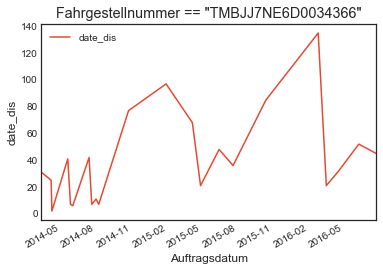

In [84]:
fig = plt.figure()
#plt.plot(a['Auftragsdatum1'], a['date_dis'])
ts = a.plot(x = 'Auftragsdatum1', y = 'date_dis')
#fig.suptitle('Fahrgestellnummer == "TMBJJ7NE6D0034366"')
ts.set_title('Fahrgestellnummer == "TMBJJ7NE6D0034366"')
plt.xlabel('Auftragsdatum')
plt.ylabel('date_dis')
ts.set_xlim(a['Auftragsdatum1'].iloc[0], a['Auftragsdatum1'].iloc[-1])

In [82]:
a['date_dis'].map(lambda x: x.days)

7583     31
7584     25
7585      2
7586     41
7587      7
7588      6
7589     42
7590      7
7591     11
7592      7
7593     77
7594     97
7595     68
7596     21
7597     48
7598     36
7599     85
7600    135
7601     21
7602     32
7603     52
7604     45
Name: date_dis, dtype: int64

 - 有些类型种类还是太多了，应该问一下分类的方法。
 - 主要分析的是，返回率大于一定阈值的客户的返回间隔
 - !!!出现了两个date_dis, 估计哪里在合并的时候出现了错误（两个表拥都拥有属性date_dis），找一下，然后给改过来
 - ！！！数据里面出现了负数，说明没有排序好，看一下
 - ！！！AW-Nr里面也出现了负数，这就不知道是什么原因了，得找找看，预计是后面处理失误，导致的
 - ！！！有些AW-Nr中间有空格，不知是何意
 - !!! timedelta化为直接整形是以秒为单位的，为了timedelta的days属性，保存这期对应的天数